### Compress features
Compress some features and look at the reslusts

### loading all datasets

In [2]:
from tabnanny import verbose

import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier

from helper_functions.helper import model_with_shap
import seaborn as sns

In [3]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/abtiters.csv')

# Load the cytokines data
cytokines = pd.read_csv('../data/cytokines_data.csv')

# Load the cyto data
cyto = pd.read_csv('../data/cyto_data.csv')


# Calculate the difference between Day 21 and Day 0 antibody titers
abtiters['titer_response'] = abtiters['Day 21'] - abtiters['Day 0']
threshold = 100  # I chose 100 based on the plot (a little trail and error)
abtiters['response_label'] = abtiters['titer_response'].apply(lambda x: 'high' if x > threshold else 'low')

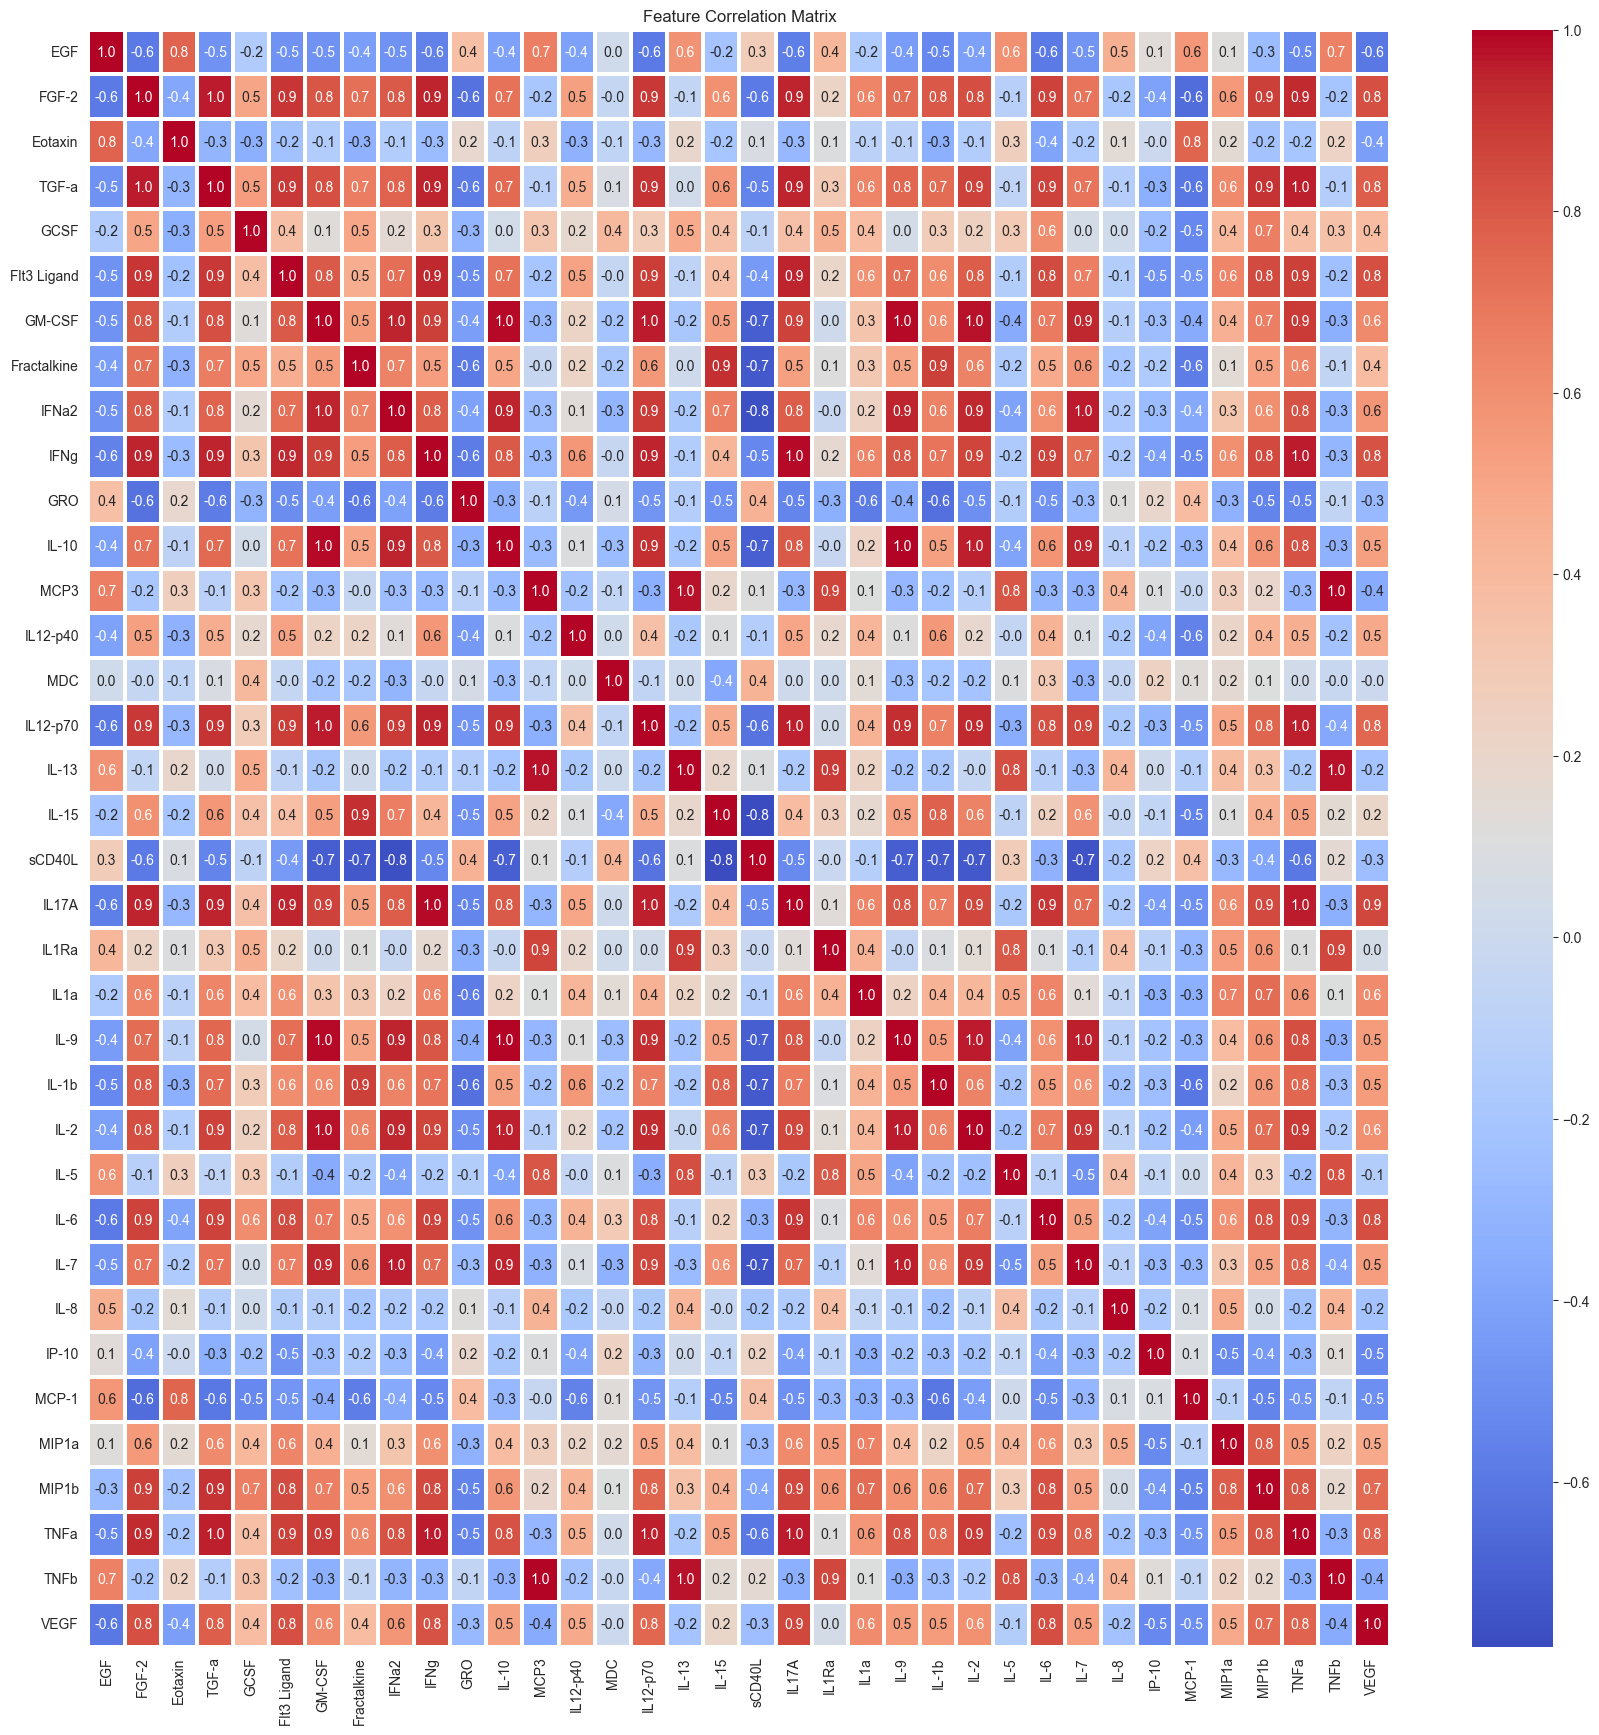

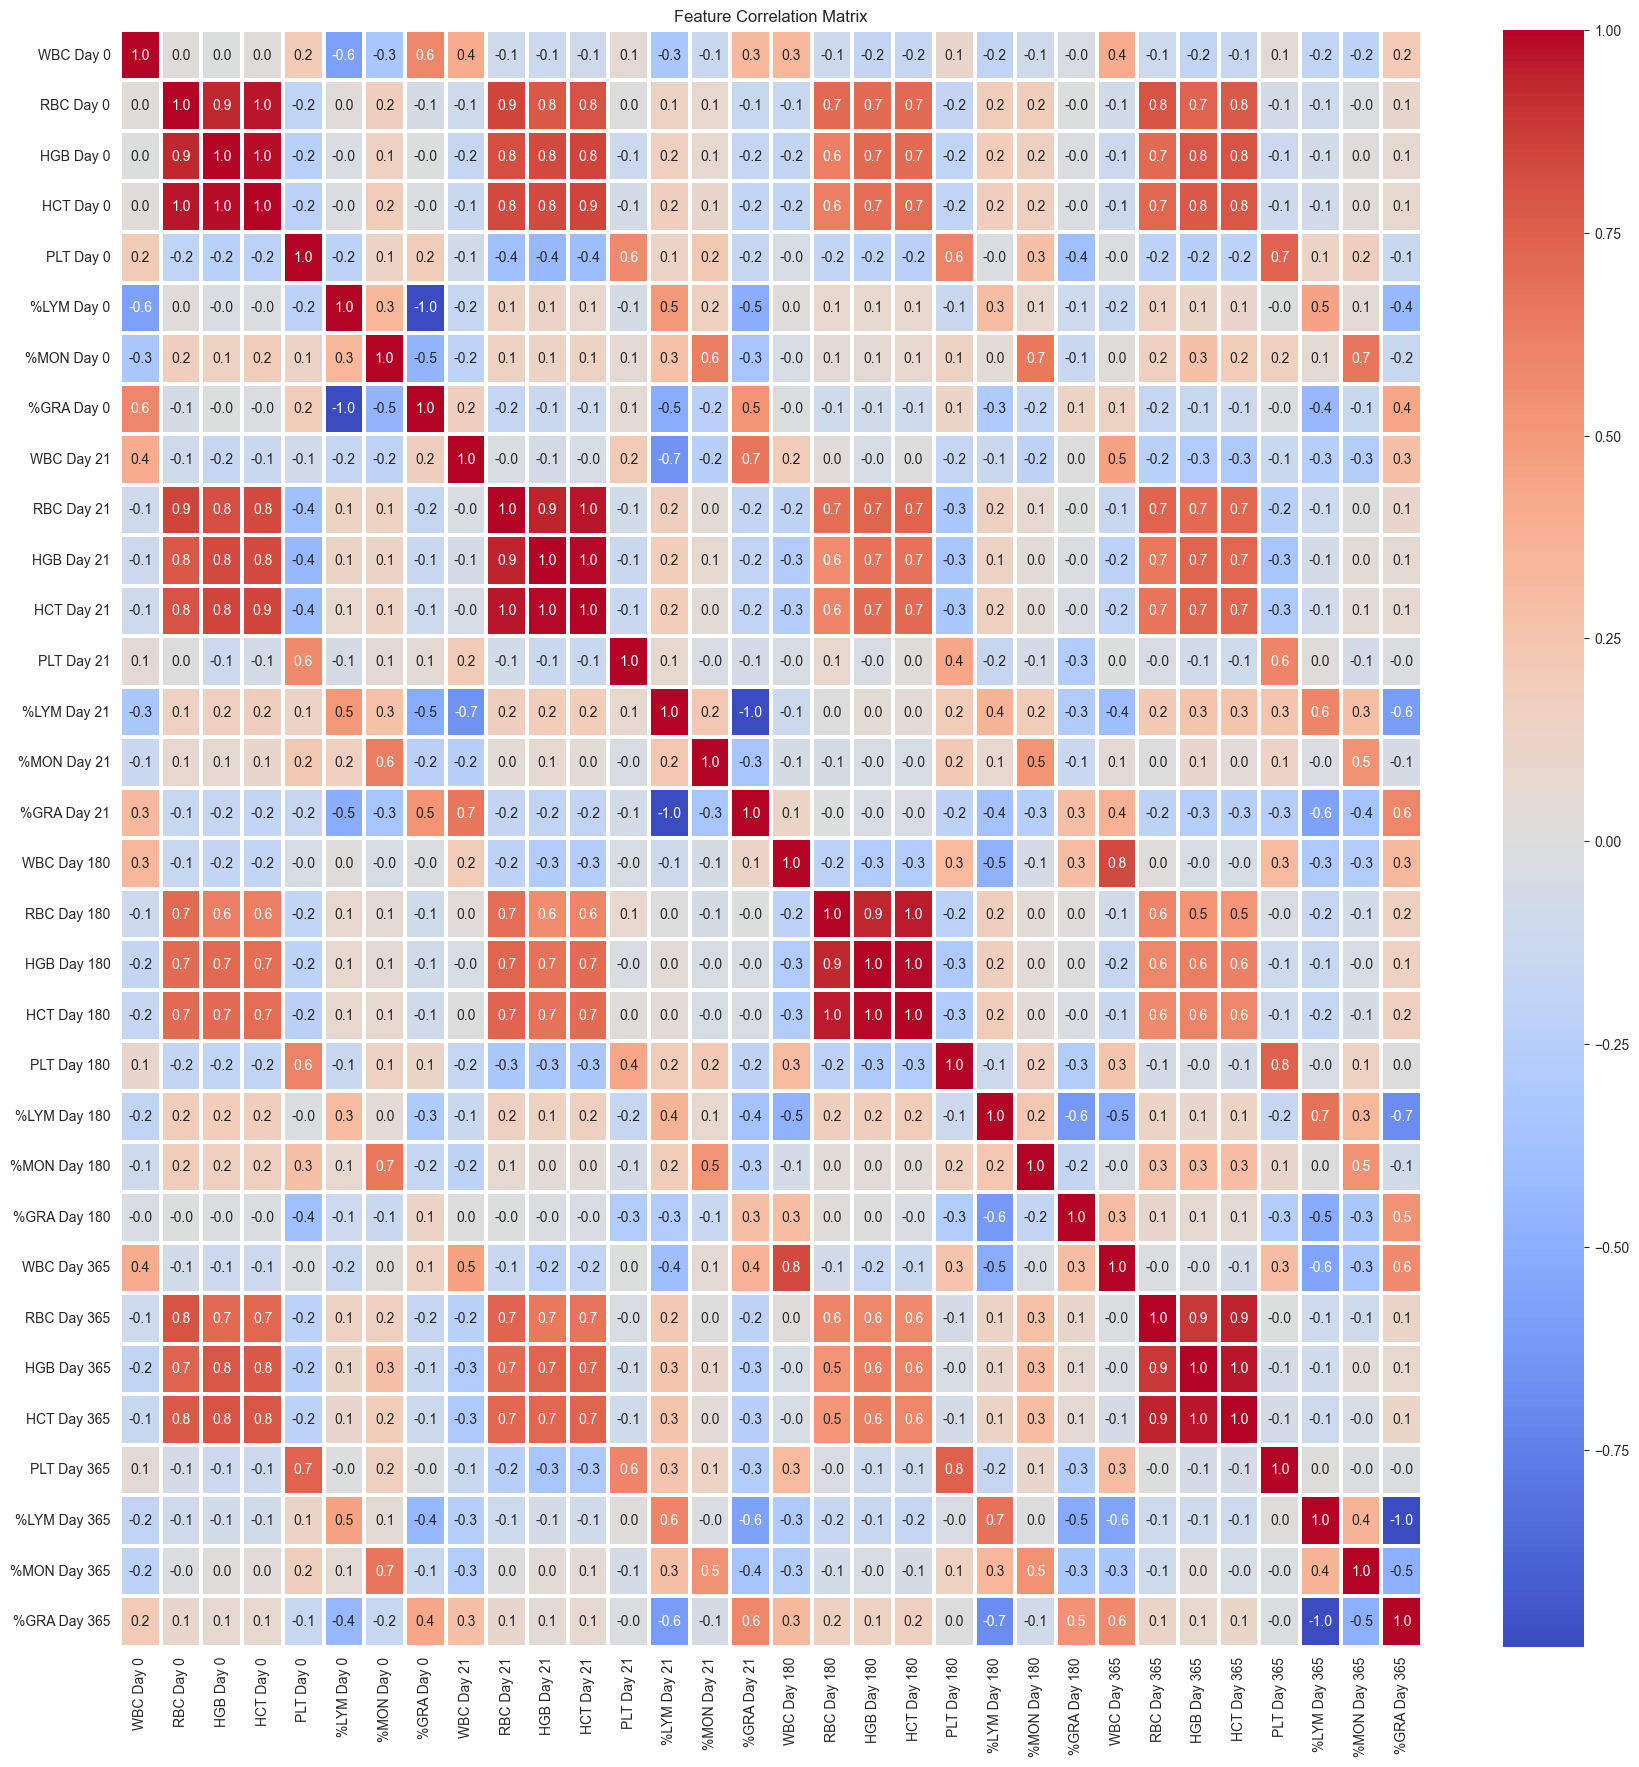

In [4]:
# Calculate the correlation matrix
cytokines_clean = cytokines.drop(columns=['Vaccinee', 'CMV.Status','EBV.Status','HSV1_2.Status','HHV6.Status']).corr()
corr_matrix = cytokines_clean.corr()

# Create a heatmap plot
plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=1.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Calculate the correlation matrix
cyto_clean = cyto.drop(columns=['Vaccinee'])
corr_matrix = cyto_clean.corr()

# Create a heatmap plot
plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=1.5)
plt.title('Feature Correlation Matrix')
plt.show()

In this cytokines plot with pearson: standard correlation coefficient.
- MIP1a and MIP1b - Positive correlation
- IL-9, IL-10, GM-CSF, IL-2, IL12-p70 - Strong positive correlation.
- TNFb, MCP3, IL-13 - Strong positive correlation.

In the cytokines plot with ward2:
- IL1Ra, TNFb, MCP3, IL-13 - Strong positive correlation.
- IL-9, IL-10, GM-CSF, IL-2, (IL-7, IFNa2) - Strong positive correlation.
- IL12-p70, IFNg, IL17A, TGF-a, TNFa (MIP1b, FGF-2), (VEGF, flt3 Ligand) - Strong positive correlation.
- Fractalkine, IL-15, (IL-1b) - Strong positive correlation.

in the cyto plot with pearson: standard correlation coefficient.
- RBC (Red Blood Cell Count), HGB (Hemoglobin), HCT (Hematocrit) - Strongly positive correlation



In [5]:
import pandas as pd
from sklearn.decomposition import PCA

# Define the groups of correlated features
group_1 = ['IL1Ra', 'TNFb', 'MCP3', 'IL-13']
group_2 = ['IL-9', 'IL-10', 'GM-CSF', 'IL-2'] # ,'IL-7', 'IFNa2'
group_3 = ['IL12-p70', 'IFNg', 'IL17A', 'TGF-a', 'TNFa'] # ,'MIP1b', 'FGF-2', 'VEGF', 'Flt3 Ligand'
group_4 = ['Fractalkine', 'IL-15'] # ,'IL-1b' 

# Perform PCA on each group and create a new feature based on the first principal component
def compress_features(data, features, new_feature_name):
    pca = PCA(n_components=1)  # We only need the first principal component
    principal_component = pca.fit_transform(data[features])
    data[new_feature_name] = principal_component
    return data

# Compress the groups and create new features
cytokines = compress_features(cytokines, group_1, 'Group_1_Compressed')
cytokines = compress_features(cytokines, group_2, 'Group_2_Compressed')
cytokines = compress_features(cytokines, group_3, 'Group_3_Compressed')
cytokines = compress_features(cytokines, group_4, 'Group_4_Compressed')

# Drop the original features that are now compressed
cytokines.drop(columns=group_1 + group_2 + group_3 + group_4, inplace=True)

# Print the updated dataframe to verify the new compressed features
print(cytokines.head())

  Vaccinee  CMV.Status  EBV.Status  HSV1_2.Status  HHV6.Status     EGF  \
0       M1           1           1              0            0  278.88   
1       M2           1           1              0            0  238.38   
2       M3           0           1              0            1   96.75   
3       M4           0           0              0            1  376.30   
4       M5           0           1              0            1  245.51   

    FGF-2  Eotaxin   GCSF  Flt3 Ligand  ...   IL-8   IP-10   MCP-1  MIP1a  \
0  497.14   189.07  20.26       128.84  ...  57.72  111.55  379.73  44.27   
1   33.20   206.11   2.36         3.81  ...  18.02  113.51  539.30   2.92   
2  166.84    96.33   2.36         3.81  ...  14.43   80.61  322.33  16.17   
3   33.20   315.78   2.36        25.17  ...  24.07  103.81  970.24  16.81   
4  198.73   105.88   2.36       177.75  ...  23.04   66.37  299.30  27.36   

    MIP1b    VEGF  Group_1_Compressed  Group_2_Compressed  Group_3_Compressed  \
0  217.44  

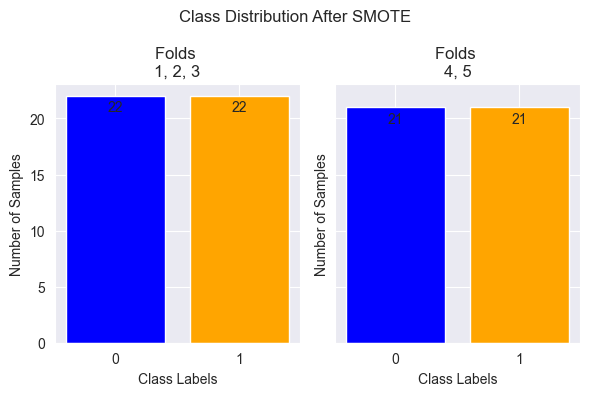

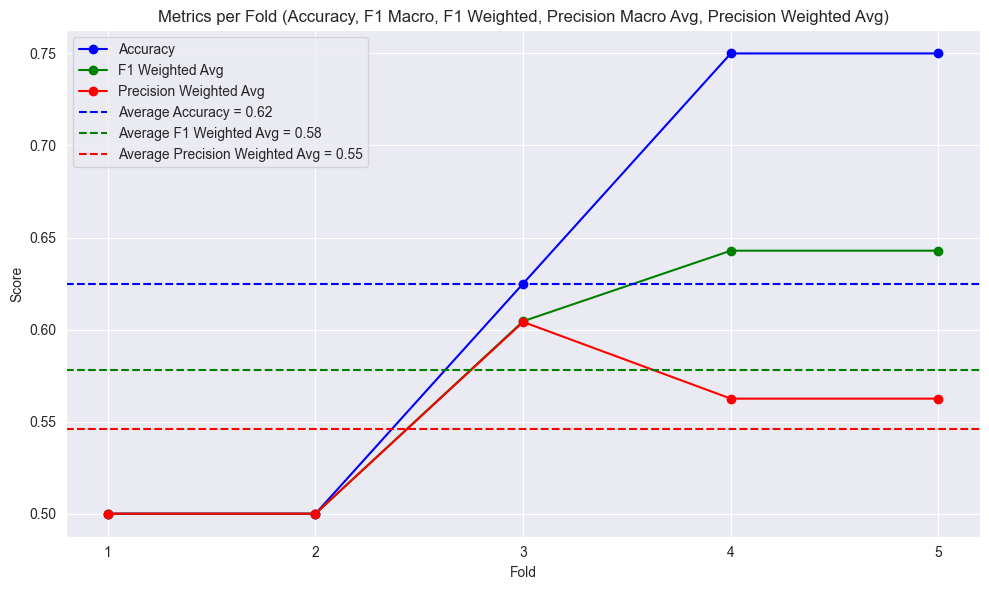

True Negatives (TN): 0.60 -> Correctly predicted negative class.
False Negatives (FN): 1.00 -> Incorrectly predicted negative class.
True Positives (TP): 4.40 -> Correctly predicted positive class.
False Positives (FP): 2.00 -> Incorrectly predicted positive class.


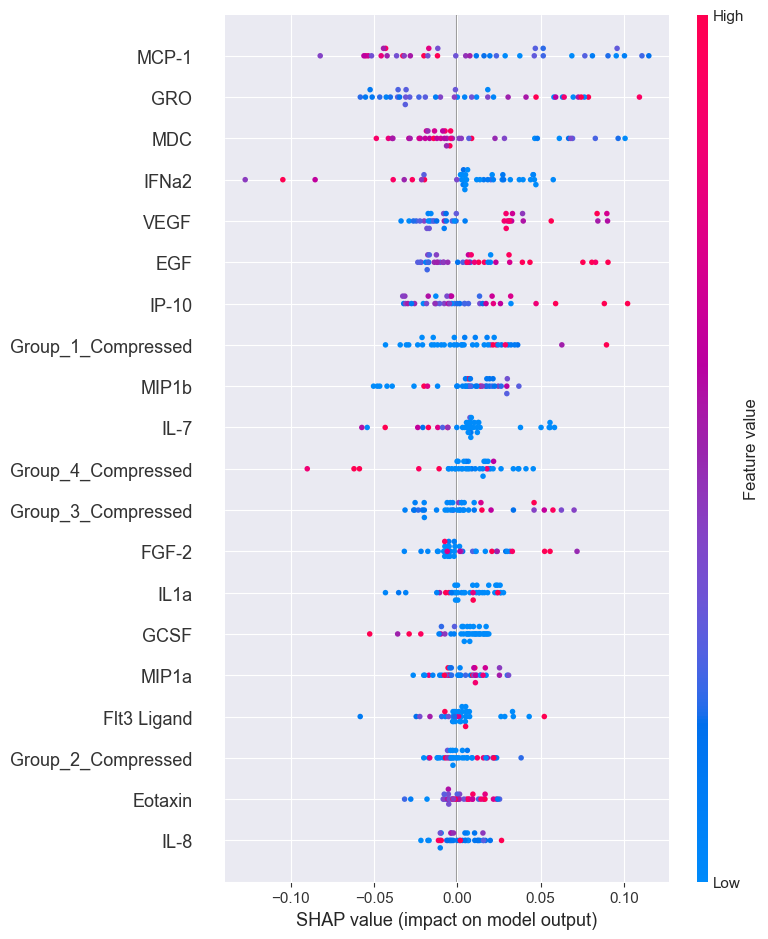

In [6]:
merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data.drop(columns=['Day 0', 'Day 21','titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['response_label']

model_with_shap(X, y, 
                crossval="K-fold", 
                n_splits=5, 
                smote=True, 
                model=RandomForestClassifier(n_estimators=100, random_state=42),
                shap_explainer = shap.TreeExplainer,
                random_state=42)

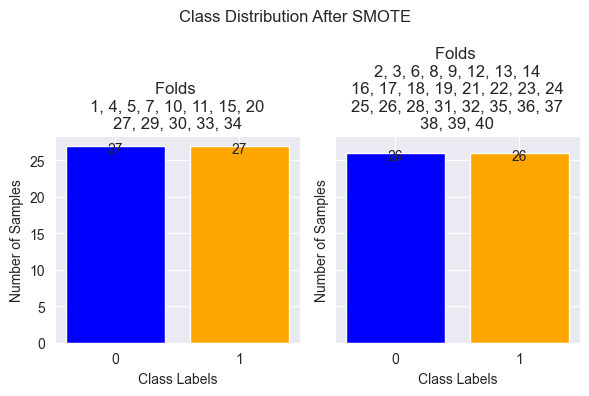

Accuracy: 0.500
f1-macro avg: 0.405
f1-weighted avg: 0.488
precision-macro avg: 0.401
precision-weighted avg: 0.478
True Negatives (TN): 2.00 -> Correctly predicted negative class.
False Negatives (FN): 9.00 -> Incorrectly predicted negative class.
True Positives (TP): 18.00 -> Correctly predicted positive class.
False Positives (FP): 11.00 -> Incorrectly predicted positive class.


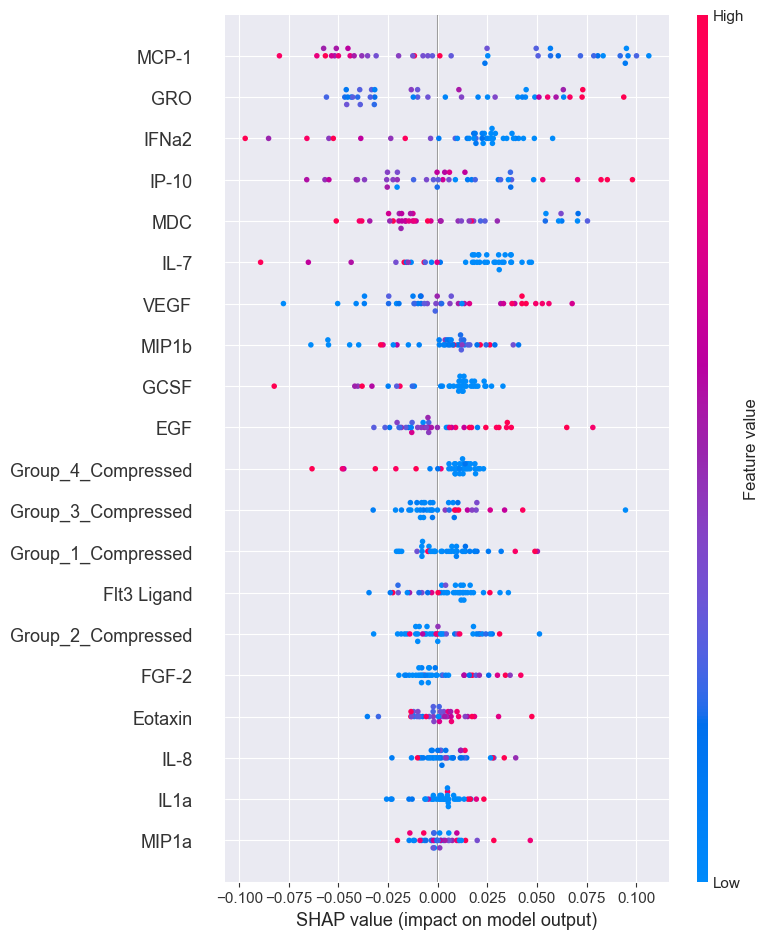

In [7]:
merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data.drop(columns=['Day 0', 'Day 21','titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['response_label']

model_with_shap(X, y, 
                crossval="Leave-One-Out",
                smote=True, 
                model=RandomForestClassifier(n_estimators=100, random_state=42),
                shap_explainer = shap.TreeExplainer,
                random_state=42)

i'm going to see if the model would perform better when i only use the 3 prominent features and it is the same

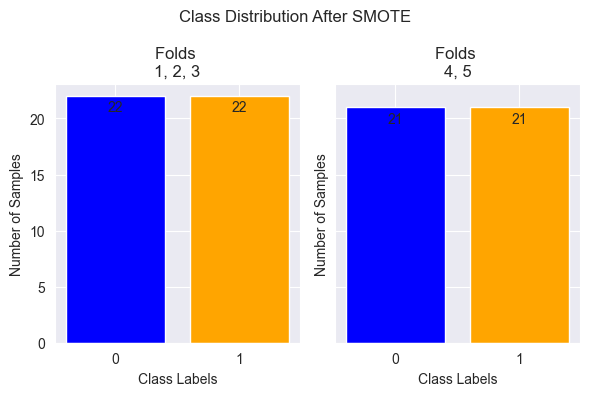

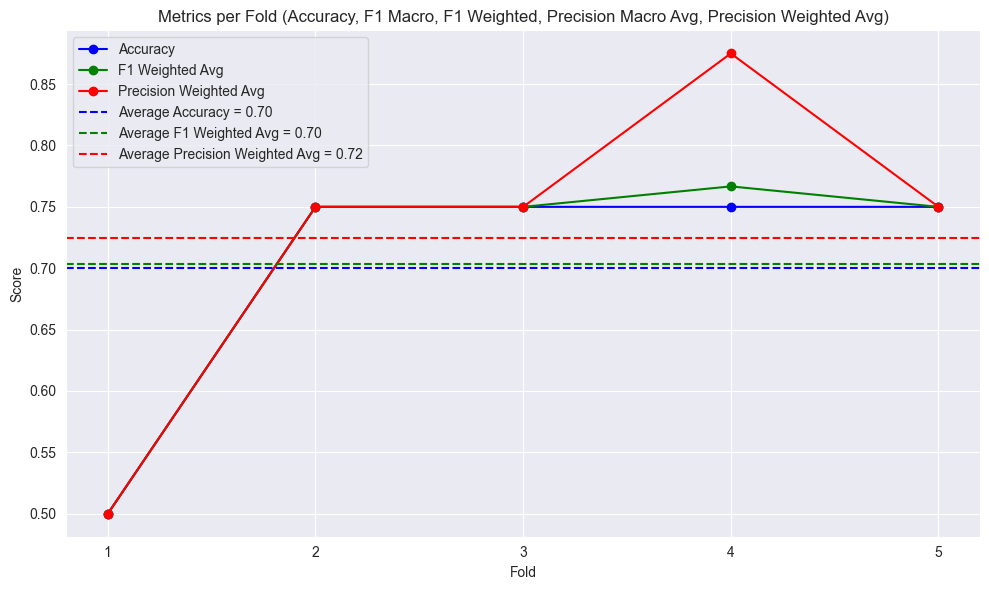

True Negatives (TN): 1.60 -> Correctly predicted negative class.
False Negatives (FN): 1.40 -> Incorrectly predicted negative class.
True Positives (TP): 4.00 -> Correctly predicted positive class.
False Positives (FP): 1.00 -> Incorrectly predicted positive class.


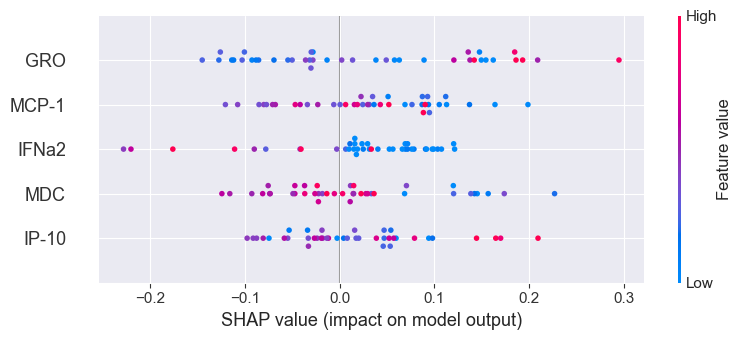

In [12]:
merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data[['GRO', 'MCP-1', 'MDC', 'IFNa2', 'IP-10']]

# Target variable
y = merged_data['response_label']

# Call the function with cross-validation enabled
model_with_shap(X, y, 
                crossval="K-fold", 
                n_splits=5, 
                smote=True, 
                model=RandomForestClassifier(n_estimators=100, random_state=42),
                shap_explainer = shap.TreeExplainer,
                random_state=42)

let's take a look at leave 1 out cross validation:

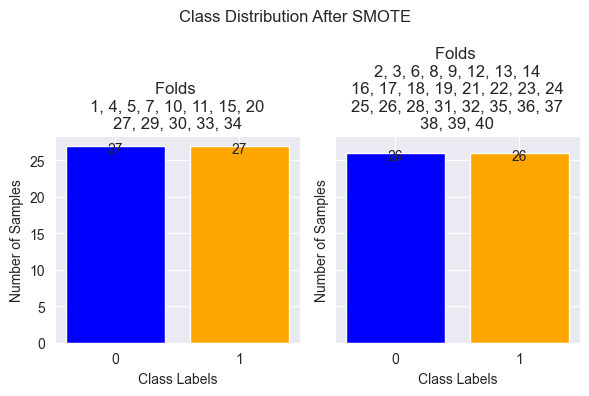

Accuracy: 0.675
f1-macro avg: 0.603
f1-weighted avg: 0.662
precision-macro avg: 0.617
precision-weighted avg: 0.657
True Negatives (TN): 5.00 -> Correctly predicted negative class.
False Negatives (FN): 5.00 -> Incorrectly predicted negative class.
True Positives (TP): 22.00 -> Correctly predicted positive class.
False Positives (FP): 8.00 -> Incorrectly predicted positive class.


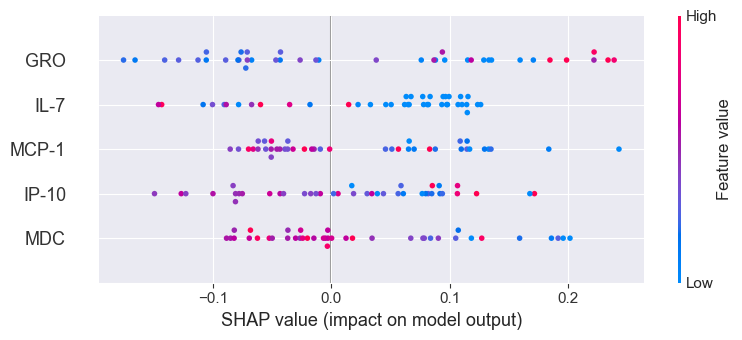

In [9]:
merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data[['GRO', 'MCP-1', 'MDC', 'IL-7', 'IP-10']]

# Target variable
y = merged_data['response_label']

model_with_shap(X, y, 
                crossval="Leave-One-Out",
                smote=True, 
                model=RandomForestClassifier(n_estimators=100, random_state=42),
                shap_explainer = shap.TreeExplainer,
                random_state=42)

### Support Vector Machine (SVM) with a Radial Basis Function (RBF) Kernel

- Why: SVMs are effective for small to medium-sized datasets, especially when the number of samples is low. The RBF kernel allows the model to capture non-linear relationships in the data, which may improve performance if your data has complex patterns.
- What to Look For: SVMs are sensitive to feature scaling, so ensure that your data is normalized. Also, SVMs can be prone to overfitting on noisy data, so you may want to try SVM with the most prominent features first.
- Evaluation Metrics: Similar to Random Forest, you can evaluate using accuracy, F1-score, and precision. You may also monitor the area under the ROC curve (AUC-ROC), which is common for binary classification problems.


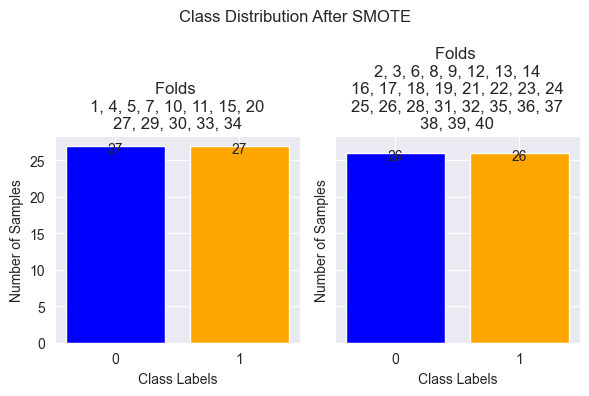

Accuracy: 0.550
f1-macro avg: 0.436
f1-weighted avg: 0.525
precision-macro avg: 0.434
precision-weighted avg: 0.508
True Negatives (TN): 2.00 -> Correctly predicted negative class.
False Negatives (FN): 7.00 -> Incorrectly predicted negative class.
True Positives (TP): 20.00 -> Correctly predicted positive class.
False Positives (FP): 11.00 -> Incorrectly predicted positive class.


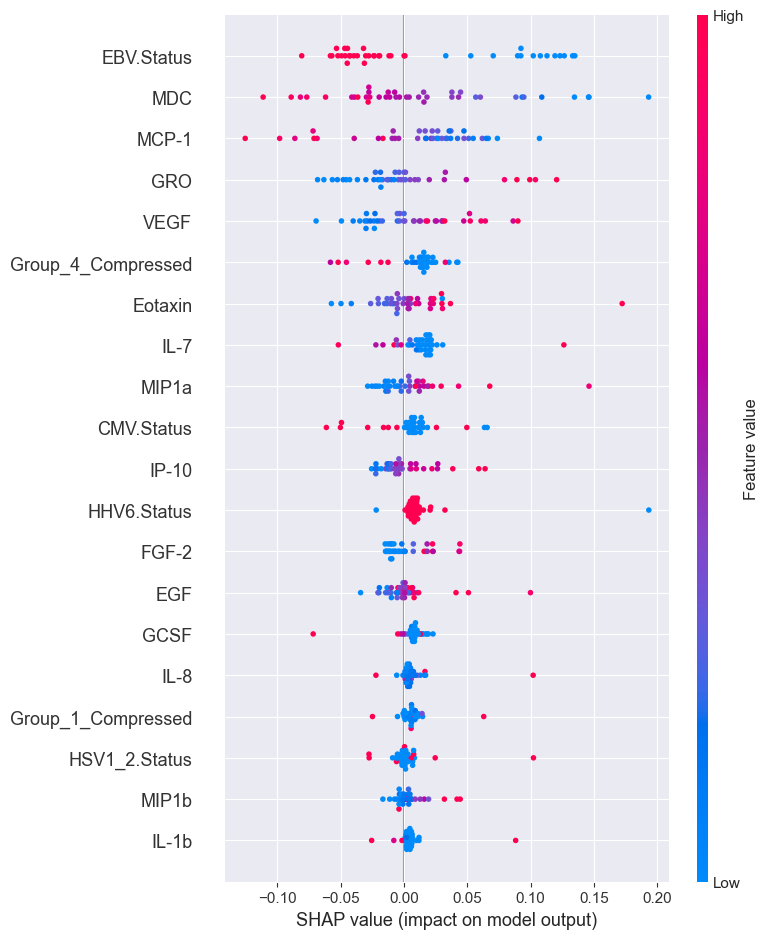

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import shap


merged_data = pd.merge(abtiters, cytokines, on='Vaccinee')

# Drop non-numeric columns
X = merged_data.drop(columns=['Day 0', 'Day 21','titer_response', 'Vaccinee', 'response_label', 'vaccine'])

# Target variable
y = merged_data['response_label']

# Standardize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)  # Convert back to DataFrame for consistency

# Call the function with the SVM model and KernelExplainer for SHAP
model_with_shap(X_normalized, y, 
                crossval="Leave-One-Out",
                n_splits=5,
                smote=True, 
                model=SVC(kernel='rbf', probability=True, random_state=42),
                shap_explainer=shap.KernelExplainer)